# Introduction
In this notebook a simplistic.version of a class of ORCT (_Optimal Randomized Classification Trees_ Blanquero et Al. 2018) is designed. This class is able to manage only iris dataset: a more general version is present in 'source' folder.

In [ ]:
# dataframe management
import pandas as pd
import math
import numpy as np
import sklearn
import json
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from functools import reduce # Valid in Python 2.6+, required in Python 3
import operator
from pyomo.environ import *
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing of dataset
Let's load the Iris dataset:

In [3]:
iris = pd.read_csv('... .csv') #IrisCategorical.csv
iris = iris.drop('Id', axis=1)
iris_std = iris.copy()

In [3]:
scaler = MinMaxScaler() # also MaxAbsScaler()

In [4]:
#Preprocessing: we get the columns names of features which have to be standardized
columns_names = list(iris)
index_features = list(range(0,len(iris_std.columns)-1))
index_instances = list(range(0,iris_std.shape[0]))

#The name of the classes K
classes = iris_std['Species'].unique().tolist()
classes_en = [i for i in range(len(classes))] 

#Encoder processing
le = preprocessing.LabelEncoder()
le.fit(iris_std['Species'])

iris_std['Species'] = le.transform(iris_std['Species']) 

#Scaling phase
iris_std[columns_names[0:4]] = scaler.fit_transform(iris_std[columns_names[0:4]])

Objects useful to deal with trees (of depth 2) and their topology

In [5]:
BF_in_NL_R = {4:[],5:[2],6:[1],7:[1,3]}
BF_in_NL_L = {4:[1,2],5:[1],6:[3],7:[]}
I_in_k = {i : list(iris_std[iris_std['Species']== i].index) for i in range(len(classes))}
my_W = {(i,j): 0.5 if i != j else 0 for i in classes_en for j in classes_en}

x = iris_std.loc[:, columns_names].values
y = iris_std.loc[:,['Species']].values
my_x = {(i,j): x[i,j] for i in index_instances for j in index_features}

In [14]:
def B_in_NR(model, i):
    if i==4:
        return []
    elif i==5:
        return [2]
    elif i==6:
        return [1]
    elif i==7:
        return [1,3]
def B_in_NL(model, i):
    if i==4:
        return [1,2]
    elif i==5:
        return [1]
    elif i==6:
        return [3]
    elif i==7:
        return []

def I_k(model,i):
    if i==0:
        return I_in_k[0]
    elif i==1:
        return I_in_k[1]
    elif i==2:
        return I_in_k[2]

A simplistic definition of class for Randomized Trees:

In [55]:
class ORCT:
    
    def __init__(self,my_x,my_W,I_in_k,BF_in_NL_R,BF_in_NL_L,B_in_NL,B_in_NR,I_k,init_a,init_mu,init_C,init_P,init_p):
        self.B_in_NL = B_in_NL 
        self.B_in_NR = B_in_NR
        self.I_k = I_k
        self.my_W = my_W
        self.I_in_k = I_in_k
        self.my_x =my_x
        self.BF_in_NL_R = BF_in_NL_R
        self.BF_in_NL_L = BF_in_NL_L
        self.index_features = list(range(0, 4))
        self.index_instances = list(range(0,150))
        self.init_a = init_a
        self.init_mu = init_mu
        self.init_C = init_C
        self.init_P = init_P
        self.init_p = init_p
        
        self.createModel()
    
    def createModel(self):
        self.model = ConcreteModel() #ConcretModel()
        self.model.I = Set(initialize=set(i for k in self.I_in_k for i in self.I_in_k[k]))
        self.model.K = Set(initialize=self.I_in_k.keys())
        self.model.I_k = Set(self.model.K,initialize=I_k)    
        self.model.f_s =Set(initialize=self.index_features)
        self.model.N_B = Set(initialize=set(i for k in self.BF_in_NL_R for i in self.BF_in_NL_R[k]))
        self.model.N_L = Set(initialize=self.BF_in_NL_R.keys())
        self.model.N_L_R = Set(self.model.N_L,initialize=self.B_in_NR)
        self.model.N_L_L = Set(self.model.N_L,initialize=self.B_in_NL)
        self.model.W = Param(self.model.K, self.model.K, within=NonNegativeReals, initialize=self.my_W)
        self.model.x = Param(self.model.I, self.model.f_s, within=PercentFraction, initialize=self.my_x)
        self.model.a = Var(self.model.f_s, self.model.N_B, within=Reals, bounds = (-1.0,1.0),initialize=self.init_a)
        self.model.mu = Var(self.model.N_B, within = Reals, bounds = (-1.0,1.0),initialize=self.init_mu)
        self.model.C = Var(self.model.K, self.model.N_L, within = PercentFraction,initialize=self.init_C)
        self.model.P = Var(self.model.I,self.model.N_L,within = PercentFraction,initialize=self.init_P)
        self.model.p = Var(self.model.I,self.model.N_B,within = PercentFraction,initialize=self.init_p)
        
        def cost_rule(model):
            return sum( sum( sum( model.P[i,t]* sum(model.W[k,j]*model.C[j,t] for j in self.model.K if k!=j)  for t in self.model.N_L) for i in self.model.I_k[k] ) for k in self.model.K )
        self.model.cost = Objective(rule=cost_rule, sense=minimize)
        def Pr(model,i,tl):
            return  reduce(operator.mul,(model.p[i,t] for t in self.model.N_L_L[tl]),1)*reduce(operator.mul,(1-model.p[i,tr] for tr in self.model.N_L_R[tl]),1) == model.P[i,tl]
        self.model.Pr = Constraint(self.model.I,self.model.N_L, rule=Pr)

        def pr(model, i , tb):
            return 1 / (1 + exp(-512*(   (sum(model.x[i,j]*model.a[j,tb]for j in self.model.f_s)/4)-model.mu[tb]  ))) ==model.p[i,tb]
        self.model.pr = Constraint(self.model.I,self.model.N_B, rule=pr)
        
        # We must add the following set of constraints for making a single class prediction at each leaf node:
        def class_in_leaf(model, tl):
            return  sum(model.C[k,tl] for k in self.model.K) == 1
        self.model.class_in_leaf = Constraint(self.model.N_L, rule=class_in_leaf)

        def leaf_in_class(model,k):
            return sum(model.C[k,tl] for tl in self.model.N_L) >=1
        self.model.leaf_in_class = Constraint(self.model.K, rule=leaf_in_class)
        
        
        
    def init_values(self):
        return [self.init_a,self.init_mu,self.init_C,self.init_P,self.init_p]
    
    def solve(self):
        """Solve the model."""
        solver = SolverFactory('ipopt',executable='C:/.../ipopt.exe')# in executable the directory path of ipopt.exe
        results = solver.solve(self.model)
        
    def value_obj(self):
        return value((self.model.cost))

An experiment with the class above defined:

In [58]:
init_a = np.random.uniform(low=-1.0, high=1.0, size=None)
init_mu = np.random.uniform(low=-1.0, high=1.0, size=None)
init_C = np.random.uniform(low=0.0, high=1.0, size=None)
init_P = np.random.uniform(low=0.0, high=1.0, size=None)
init_p = np.random.uniform(low=0.0, high=1.0, size=None)
p = ORCT(my_x,my_W,I_in_k,BF_in_NL_R,BF_in_NL_L,B_in_NL,B_in_NR,I_k,init_a,init_mu,init_C,init_P,init_p)
p.solve()
print([init_a,init_mu,init_C,init_P,init_p])
print(value(p.model.cost))

[0.7909097382417931, 0.34717530141587805, 0.857825102086188, 0.5713685746895304, 0.7664385334806046]
0.6469934607171203


We repet the experiment ten times to analyze the stability

In [66]:
a ={}
for i in range(10):
    init_a = np.random.uniform(low=-1.0, high=1.0, size=None)
    init_mu = np.random.uniform(low=-1.0, high=1.0, size=None)
    init_C = np.random.uniform(low=0.0, high=1.0, size=None)
    init_P = np.random.uniform(low=0.0, high=1.0, size=None)
    init_p = np.random.uniform(low=0.0, high=1.0, size=None)
    p = ORCT(my_x,my_W,I_in_k,BF_in_NL_R,BF_in_NL_L,B_in_NL,B_in_NR,I_k,init_a,init_mu,init_C,init_P,init_p)
    try:
        p.solve()
        a[value(p.model.cost)] = [init_a,init_mu,init_C,init_P,init_p]
    except ValueError:
        print ('Invalid value!')
    
print(a.keys())

<built-in method keys of dict object at 0x000001C95049F2D0>


Values assumed by the objective function

In [135]:
print(list(a.keys()))


[1.3401020115352236, 1.340102006894239, 1.3401019920084338, 1.3401019920078454, 1.3401020132205537, 0.6469934840682346, 0.6469934606990422, 0.6469934607141934, 1.3401019920172799, 1.3401020068949037]


In [59]:
print(value(p.model.cost))
for i in p.model.P:
    print (str(p.model.P[i]), p.model.P[i].value)

0.6469934607171203
P[0,4] 4.8939783509988934e-55
P[0,5] 7.83036536159823e-54
P[0,6] 9.00721685398602e-18
P[0,7] 1.0
P[1,4] 7.952714820373202e-55
P[1,5] 7.83036536159823e-54
P[1,6] 4.997979702935416e-15
P[1,7] 0.9999999999999949
P[2,4] 4.6900625863739395e-55
P[2,5] 1.0766752372197565e-53
P[2,6] 0.0
P[2,7] 1.0
P[3,4] 9.787956701997787e-55
P[3,5] 1.0766752372197565e-53
P[3,6] 0.0
P[3,7] 1.0
P[4,4] 4.8939783509988934e-55
P[4,5] 7.748799055748248e-54
P[4,6] 2.229100988980961e-19
P[4,7] 1.0
P[5,4] 1.1215367054372464e-54
P[5,5] 6.28060555044858e-54
P[5,6] 2.257116803766487e-15
P[5,7] 0.9999999999999979
P[6,4] 4.8939783509988934e-55
P[6,5] 6.362171856298561e-54
P[6,6] 0.0
P[6,7] 1.0
P[7,4] 4.8939783509988934e-55
P[7,5] 5.22024357439882e-54
P[7,6] 6.931566470992963e-17
P[7,7] 1.0
P[8,4] 1.1215367054372464e-54
P[8,5] 7.83036536159823e-54
P[8,6] 0.0
P[8,7] 1.0
P[9,4] 9.787956701997787e-55
P[9,5] 6.210821630023875e-48
P[9,6] 1.7048563448178577e-16
P[9,7] 0.9999999999999999
P[10,4] 4.89397835099889

P[115,4] 0.9999999997968072
P[115,5] 2.0316615056965964e-10
P[115,6] 2.664535259418623e-14
P[115,7] 0.0
P[116,4] 0.9999993800983104
P[116,5] 6.198084052088561e-07
P[116,6] 9.328449124695833e-11
P[116,7] 0.0
P[117,4] 0.9999999999990392
P[117,5] 9.552358903872904e-13
P[117,6] 5.5511151241607485e-15
P[117,7] 0.0
P[118,4] 0.9999999999996354
P[118,5] 3.6459724128650736e-13
P[118,6] 2.0646471168276582e-54
P[118,7] 3.313631175155501e-55
P[119,4] 0.9842037728197506
P[119,5] 0.01579622718024939
P[119,6] 0.0
P[119,7] 3.67048376324917e-55
P[120,4] 0.9999999993075852
P[120,5] 6.924147921691617e-10
P[120,6] 1.0928967196348197e-29
P[120,7] 3.313631175155501e-55
P[121,4] 0.9999999993758621
P[121,5] 2.7183966179596157e-10
P[121,6] 3.5229819064059257e-10
P[121,7] 0.0
P[122,4] 0.9999999965307329
P[122,5] 3.4692670958211355e-09
P[122,6] 5.857813948664271e-44
P[122,7] 3.313631175155501e-55
P[123,4] 0.9805368793797732
P[123,5] 0.019463120619379853
P[123,6] 8.468781231810346e-13
P[123,7] 0.0
P[124,4] 0.9999

The same experiment repeated 100 times

In [81]:
b ={}
for i in range(100):
    init_a = np.random.uniform(low=-1.0, high=1.0, size=None)
    init_mu = np.random.uniform(low=-1.0, high=1.0, size=None)
    init_C = np.random.uniform(low=0.0, high=1.0, size=None)
    init_P = np.random.uniform(low=0.0, high=1.0, size=None)
    init_p = np.random.uniform(low=0.0, high=1.0, size=None)
    p = ORCT(my_x,my_W,I_in_k,BF_in_NL_R,BF_in_NL_L,B_in_NL,B_in_NR,I_k,init_a,init_mu,init_C,init_P,init_p)
    try:
        p.solve()
        b[value(p.model.cost)] = [init_a,init_mu,init_C,init_P,init_p]
    except ValueError:
        print ('Invalid value!')

Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!


Graphical analysis

Text(0.5, 0, 'Min values: 0.646993, 1.340102, 15.156403')

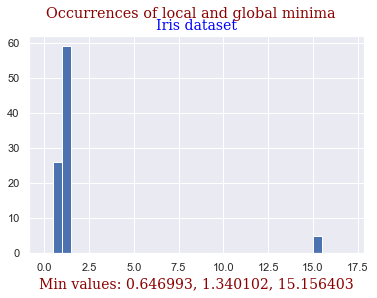

In [134]:
sns.set(color_codes=True)
pinco = b.keys()
value_objective = list(b.keys())
f = [i for i in value_objective if i<=0.7]
fir = reduce(lambda x, y: x + y, f) / len(f)
s = [i for i in value_objective if i>=0.7 and i<=5]
sec = reduce(lambda x, y: x + y, s) / len(s)
t = [i for i in value_objective if i>5 and i <=17]
th = reduce(lambda x, y: x + y, t) / len(t)

#[i  for i in pinco if i <= 10]

font1 = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }
font2 = {'family': 'serif',
        'color':  'blue',
        'weight': 'normal',
        'size': 14,
        }
bin = np.arange(0,17.5,0.5)
plt.hist(value_objective,bins = bin)
plt.suptitle("Occurrences of local and global minima", fontdict=font1)
plt.title("Iris dataset", fontdict=font2)
plt.xlabel('Min values: %f, %f, %f'%(fir,sec,th), fontdict=font)

In [136]:
with open('data.txt', 'w') as outfile:  
    json.dump(b, outfile)